In [1]:
import mrsobs

import numpy as np
from astropy.io import fits
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
plt.style.use('presentation')
%matplotlib notebook

import warnings
warnings.simplefilter('ignore')

In [3]:
workDir  = '/Users/ioannisa/Desktop/python/miri_devel/'
lvl1path = '/Volumes/miri_mrs_data/FM_MRS/'
lvl2path = workDir+'FM_data/LVL2/'
cdpDir   = workDir+'cdp_data/'

In [5]:
# Get data
band     = '1A'
ext_source_sci,ext_source_bkg = mrsobs.FM_MTS_BB_extended_source(lvl2path,band,bb_temp='800K')
ext_source_bkgsubtr = ext_source_sci-ext_source_bkg

ext_source_hdu  = fits.open(lvl1path+'FM1T00011282/MIRFM1T00011282_1_495_SE_2011-05-31T02h15m32.fits') # band 1A
ext_source_ramp = ext_source_hdu[0].data

bkg_exp_hdu = fits.open(lvl1path+'FM1T00011285/MIRFM1T00011285_1_495_SE_2011-05-31T05h06m47.fits') # band 1A
bkg_exp_ramp = bkg_exp_hdu[0].data

sci_ramp = ext_source_ramp-bkg_exp_ramp # this is not how the background should be subtracted, this should be done at the MRS data lvl2 (find a dark patch of sky in the FOV to subtract)

In [6]:
print(repr(ext_source_hdu[0].header))

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                   16 / array data type                                
NAXIS   =                    3 / number of array dimensions                     
NAXIS1  =                 1032                                                  
NAXIS2  =                 1280                                                  
NAXIS3  =                  120 / length of third data axis                      
EXTEND  =                    T                                                  
                                                                                
                                                                                
                                                                                
DATE    = '2011-05-31T02:15:41' / date file created (yyyy-mm-ddThh:mm:ss,UTC)   
BSCALE  =                    1 / scale factor for array value to physical value 
BZERO   =                327

In [7]:
nints = ext_source_hdu[0].header['NINT']
ngroups = ext_source_hdu[0].header['NGROUP']
frame_delta_time = ext_source_hdu[0].header['TFRAME']
print ext_source_ramp.shape

(120, 1280, 1032)


<IPython.core.display.Javascript object>


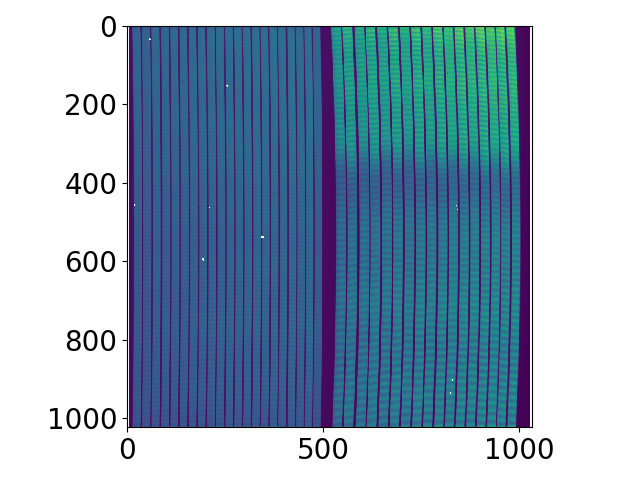

In [8]:
plt.figure()
plt.imshow(ext_source_bkgsubtr)
plt.tight_layout()

In [38]:
# Linearity Correction
linearityCorrection = fits.open(cdpDir+'MIRI_FM_RAL_MIRIFUSHORT_12_LINEARITY_07.02.00.fits')[1].data
raw_sci_img   = ext_source_ramp[:,:1024,:].copy() # ommit non-sensitive pixels
raw_bkg_img   = bkg_exp_ramp[:,:1024,:].copy() # ommit non-sensitive pixels

raw_sci_img_linCorr,raw_bkg_img_linCorr = np.full(raw_sci_img.shape,0.),np.full(raw_bkg_img.shape,0.)
for i in range(raw_sci_img.shape[0]):
    raw_sci_img_linCorr[i,:,:] += linearityCorrection[0,:,:]+\
                                    linearityCorrection[1,:,:]*raw_sci_img[i,:,:]+\
                                    linearityCorrection[2,:,:]*raw_sci_img[i,:,:]**2+\
                                    linearityCorrection[3,:,:]*raw_sci_img[i,:,:]**3+\
                                    linearityCorrection[4,:,:]*raw_sci_img[i,:,:]**4
    raw_bkg_img_linCorr[i,:,:] += linearityCorrection[0,:,:]+\
                                    linearityCorrection[1,:,:]*raw_bkg_img[i,:,:]+\
                                    linearityCorrection[2,:,:]*raw_bkg_img[i,:,:]**2+\
                                    linearityCorrection[3,:,:]*raw_bkg_img[i,:,:]**3+\
                                    linearityCorrection[4,:,:]*raw_bkg_img[i,:,:]**4

/Users/ioannisa/anaconda2/envs/miricle.20170307/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in power
/Users/ioannisa/anaconda2/envs/miricle.20170307/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in power


<IPython.core.display.Javascript object>


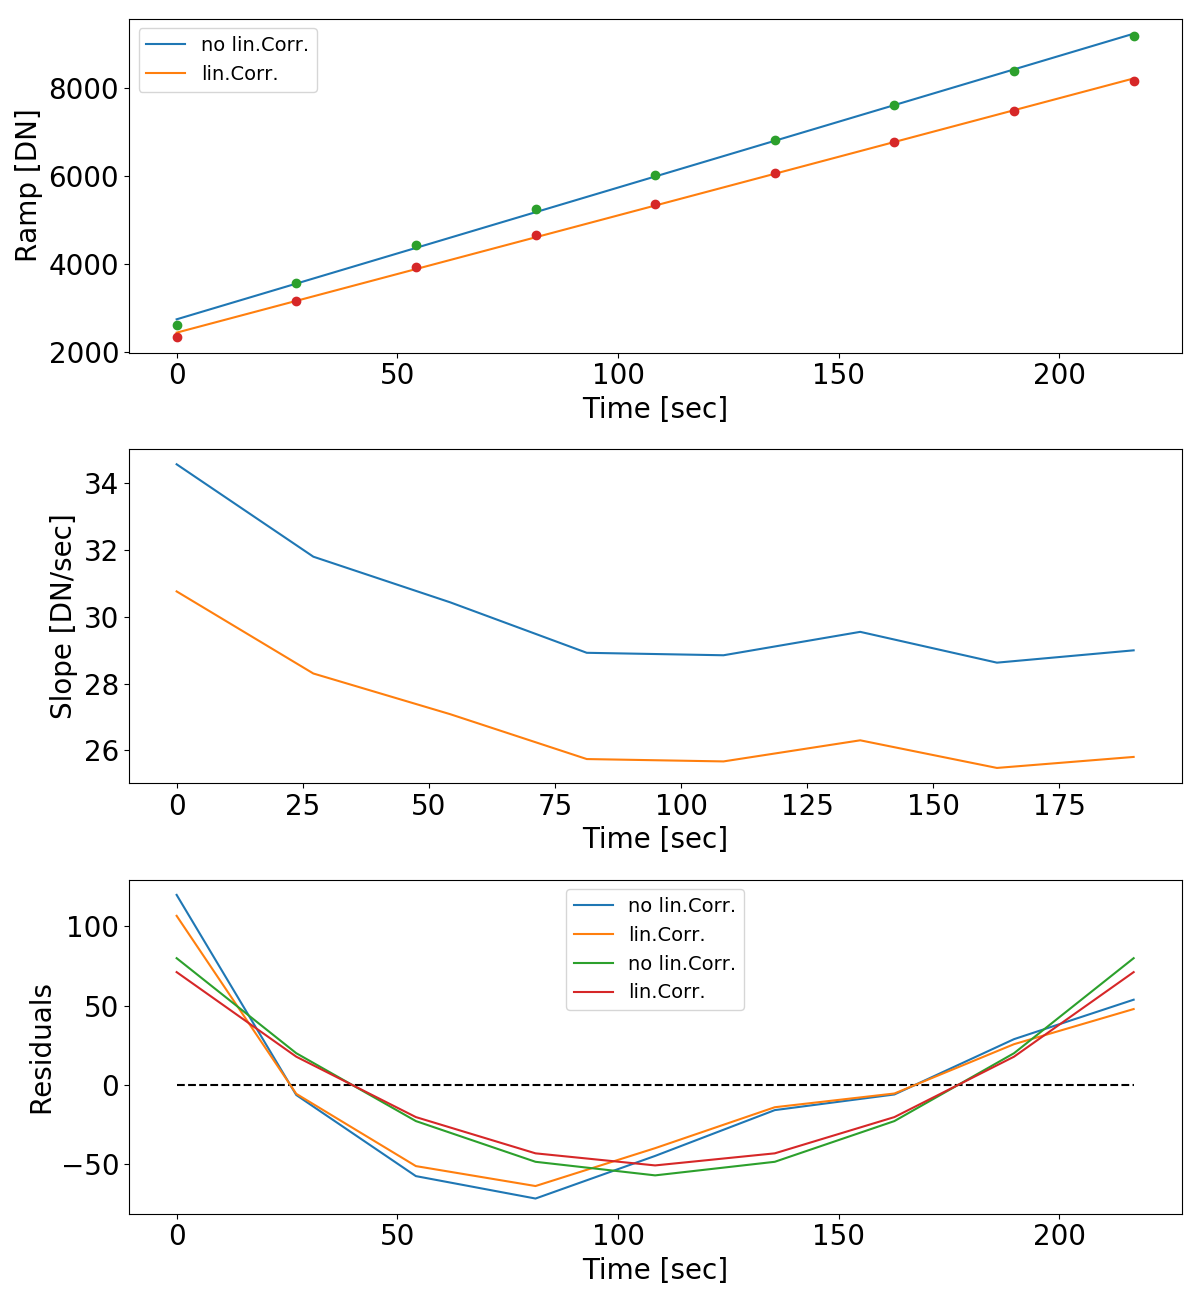

Determined slope: 29.92 DN/sec
Determined slope (lin.corr.): 26.62 DN/sec
DHAS-estimated slope: 26.97 DN/sec


In [48]:
ypos,xpos = 177,27
fig,axs = plt.subplots(3,1,figsize=(12,13))
for i in [2]: # range(nints):
    xdata  = np.arange(ext_source_ramp.shape[0]/nints)*frame_delta_time
    ydata  = ext_source_ramp[i*ngroups:(i+1)*ngroups,ypos,xpos]
    ydata_linCorr = raw_sci_img_linCorr[i*ngroups:(i+1)*ngroups,ypos,xpos]
    n_poly = 1
    
    popt = np.polyfit(xdata,ydata,n_poly) # ,w=1/sigma
    poly = np.poly1d(popt)
    
    popt_linCorr = np.polyfit(xdata,ydata_linCorr,n_poly) # ,w=1/sigma
    poly_linCorr = np.poly1d(popt_linCorr)
    
    residuals = poly(xdata)-ydata
    residuals_linCorr = poly_linCorr(xdata)-ydata_linCorr
    
    popt2 = np.polyfit(xdata,residuals,n_poly+1) # ,w=1/sigma
    poly2 = np.poly1d(popt2)
    
    popt2_linCorr = np.polyfit(xdata,residuals_linCorr,n_poly+1) # ,w=1/sigma
    poly2_linCorr = np.poly1d(popt2_linCorr)

    axs[0].plot(xdata,poly(xdata),label='no lin.Corr.')
    axs[0].plot(xdata,poly_linCorr(xdata),label='lin.Corr.')
    axs[0].plot(xdata,ydata,'o')
    axs[0].plot(xdata,ydata_linCorr,'o')
    axs[0].set_xlabel('Time [sec]')
    axs[0].set_ylabel('Ramp [DN]')
    axs[0].legend(loc='upper left')
    axs[1].plot(xdata[:-1],np.diff(ydata)/frame_delta_time,label='no lin.Corr.')
    axs[1].plot(xdata[:-1],np.diff(ydata_linCorr)/frame_delta_time,label='lin.Corr.')
    axs[1].set_xlabel('Time [sec]')
    axs[1].set_ylabel('Slope [DN/sec]')
    axs[2].plot(xdata,residuals,label='no lin.Corr.')
#     axs[2].plot(xdata,poly(xdata)-ydata,'o')
    axs[2].plot(xdata,residuals_linCorr,label='lin.Corr.')
    axs[2].plot(xdata,poly2(xdata),label='no lin.Corr.')
    axs[2].plot(xdata,poly2_linCorr(xdata),label='lin.Corr.')
    axs[2].set_xlabel('Time [sec]')
    axs[2].set_ylabel('Residuals')
    axs[2].legend(loc='upper center')
axs[2].hlines(0,0,xdata[-1],linestyle='dashed')
plt.tight_layout()

print 'Determined slope: {} DN/sec'.format(round(popt[0],2))
print 'Determined slope (lin.corr.): {} DN/sec'.format(round(popt_linCorr[0],2))
print 'DHAS-estimated slope: {} DN/sec'.format(round(ext_source_bkgsubtr[ypos,xpos],2))

<IPython.core.display.Javascript object>


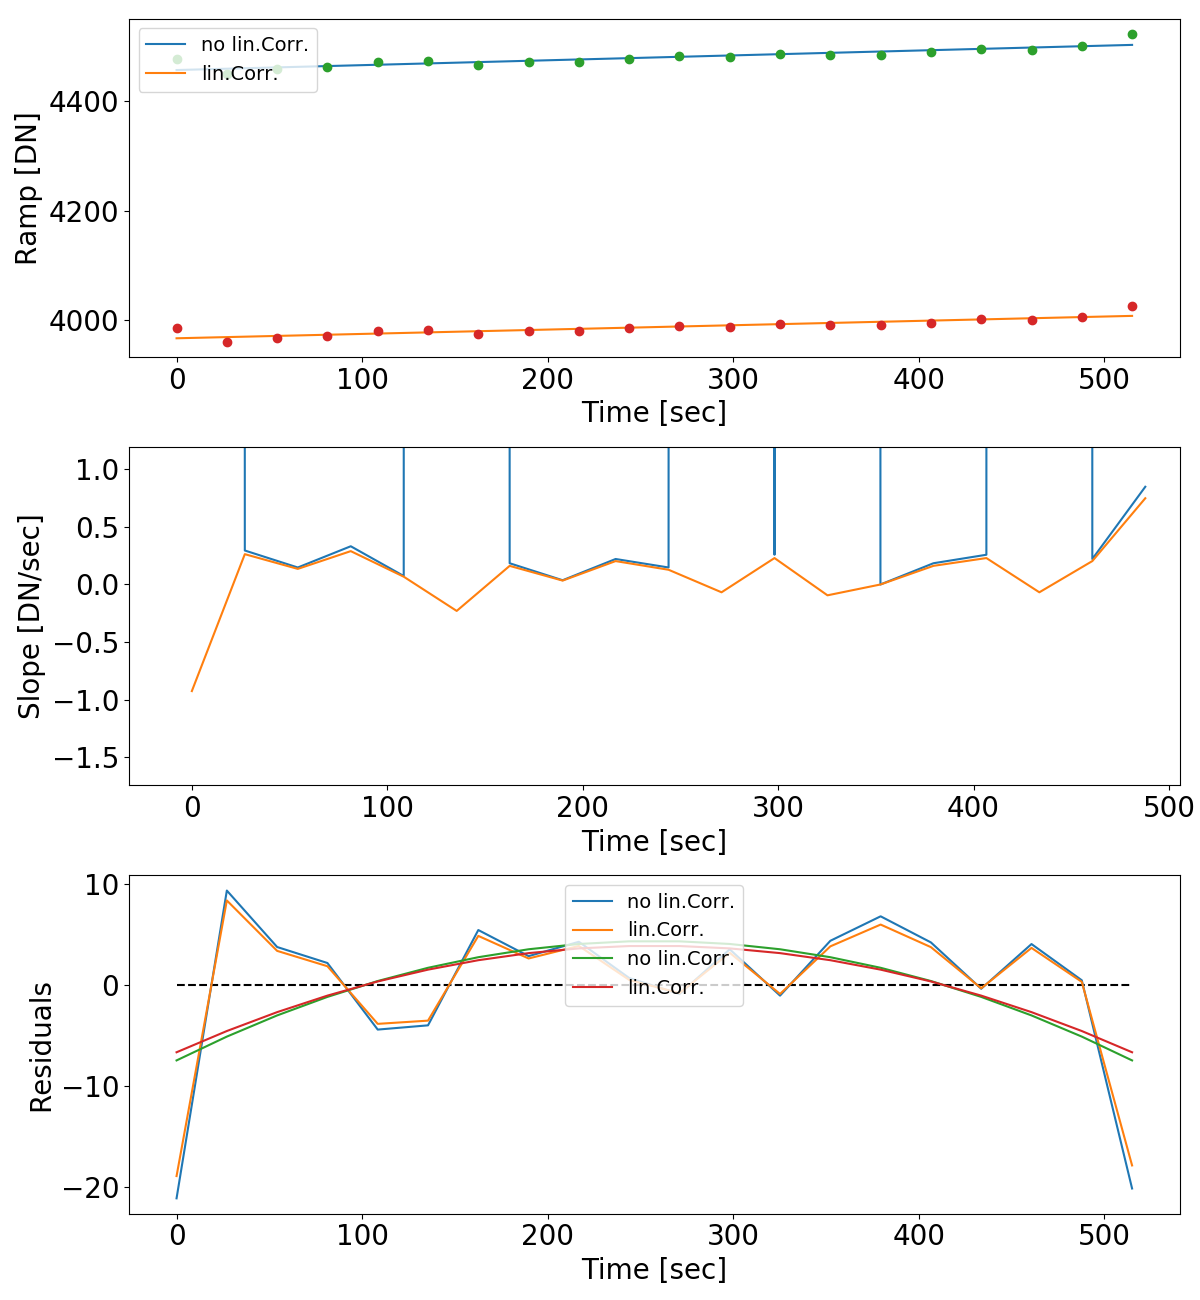

Determined slope: 0.09 DN/sec
Determined slope (lin.corr.): 0.08 DN/sec
DHAS-estimated slope: 26.97 DN/sec


In [40]:
ypos,xpos = 177,27
fig,axs = plt.subplots(3,1,figsize=(12,13))
for i in [2]: # range(nints):
    xdata  = np.arange(bkg_exp_ramp.shape[0]/nints)*frame_delta_time
    ydata  = bkg_exp_ramp[i*ngroups:(i+1)*ngroups,ypos,xpos]
    ydata_linCorr = raw_bkg_img_linCorr[i*ngroups:(i+1)*ngroups,ypos,xpos]
    n_poly = 1
    
    popt = np.polyfit(xdata,ydata,n_poly) # ,w=1/sigma
    poly = np.poly1d(popt)
    
    popt_linCorr = np.polyfit(xdata,ydata_linCorr,n_poly) # ,w=1/sigma
    poly_linCorr = np.poly1d(popt_linCorr)
    
    residuals = poly(xdata)-ydata
    residuals_linCorr = poly_linCorr(xdata)-ydata_linCorr
    
    popt2 = np.polyfit(xdata,residuals,n_poly+1) # ,w=1/sigma
    poly2 = np.poly1d(popt2)
    
    popt2_linCorr = np.polyfit(xdata,residuals_linCorr,n_poly+1) # ,w=1/sigma
    poly2_linCorr = np.poly1d(popt2_linCorr)

    axs[0].plot(xdata,poly(xdata),label='no lin.Corr.')
    axs[0].plot(xdata,poly_linCorr(xdata),label='lin.Corr.')
    axs[0].plot(xdata,ydata,'o')
    axs[0].plot(xdata,ydata_linCorr,'o')
    axs[0].set_xlabel('Time [sec]')
    axs[0].set_ylabel('Ramp [DN]')
    axs[0].legend(loc='upper left')
    axs[1].plot(xdata[:-1],np.diff(ydata)/frame_delta_time,label='no lin.Corr.')
    axs[1].plot(xdata[:-1],np.diff(ydata_linCorr)/frame_delta_time,label='lin.Corr.')
    axs[1].set_xlabel('Time [sec]')
    axs[1].set_ylabel('Slope [DN/sec]')
    axs[2].plot(xdata,residuals,label='no lin.Corr.')
#     axs[2].plot(xdata,poly(xdata)-ydata,'o')
    axs[2].plot(xdata,residuals_linCorr,label='lin.Corr.')
    axs[2].plot(xdata,poly2(xdata),label='no lin.Corr.')
    axs[2].plot(xdata,poly2_linCorr(xdata),label='lin.Corr.')
    axs[2].set_xlabel('Time [sec]')
    axs[2].set_ylabel('Residuals')
    axs[2].legend(loc='upper center')
axs[2].hlines(0,0,xdata[-1],linestyle='dashed')
plt.tight_layout()

print 'Determined slope: {} DN/sec'.format(round(popt[0],2))
print 'Determined slope (lin.corr.): {} DN/sec'.format(round(popt_linCorr[0],2))
print 'DHAS-estimated slope: {} DN/sec'.format(round(ext_source_bkgsubtr[ypos,xpos],2))

<IPython.core.display.Javascript object>


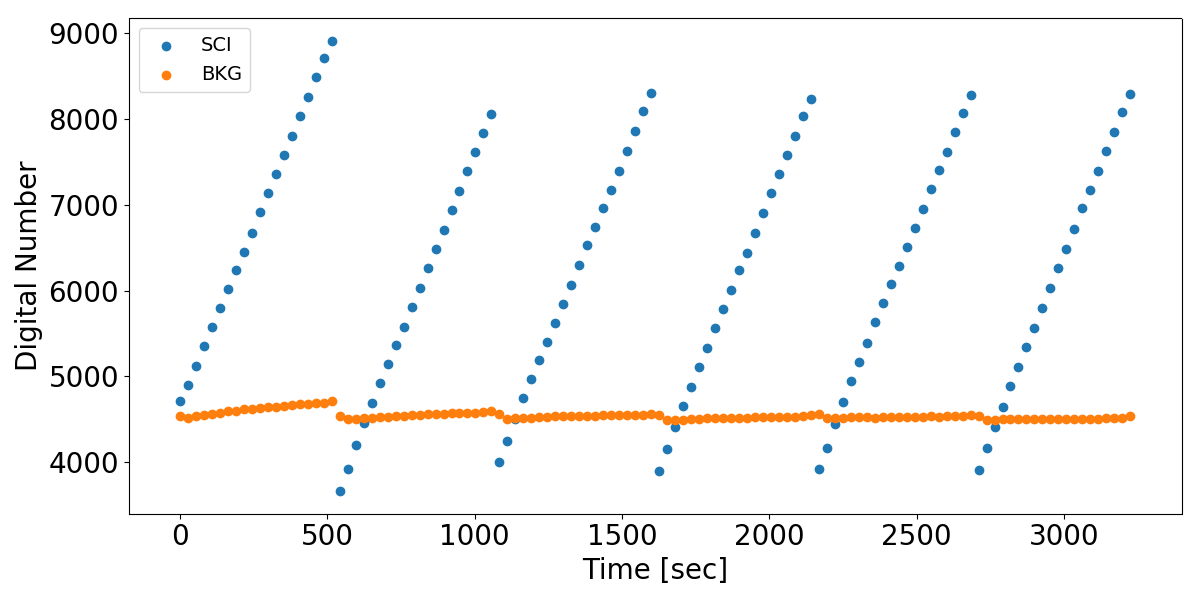

<IPython.core.display.Javascript object>


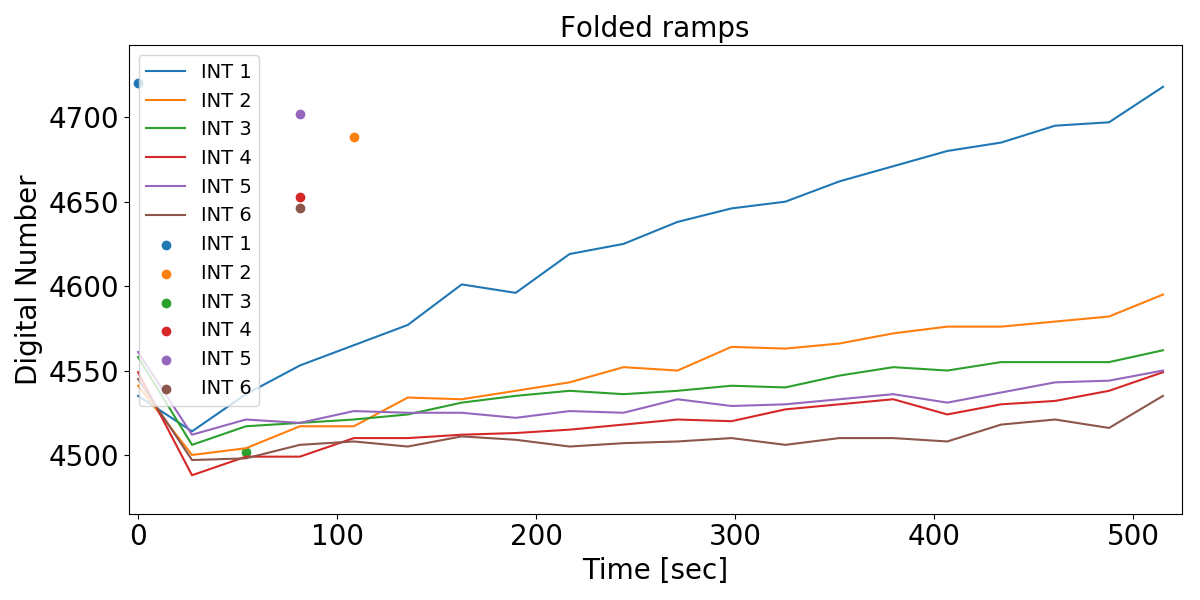

In [29]:
plt.figure(figsize=(12,6))
plt.scatter(np.arange(ext_source_ramp.shape[0])*frame_delta_time,ext_source_ramp[:,27,177],label='SCI')
plt.scatter(np.arange(bkg_exp_ramp.shape[0])*frame_delta_time,bkg_exp_ramp[:,27,177],label='BKG')
plt.xlabel('Time [sec]')
plt.ylabel('Digital Number')
plt.legend(loc='upper left')
plt.tight_layout()

plt.figure(figsize=(12,6))
plt.title('Folded ramps')
for i in range(nints):
    plt.scatter(np.arange(ext_source_ramp.shape[0]/nints)*frame_delta_time,ext_source_ramp[i*ngroups:(i+1)*ngroups,27,177],label='INT {}'.format(i+1))
    plt.plot(np.arange(bkg_exp_ramp.shape[0]/nints)*frame_delta_time,bkg_exp_ramp[i*ngroups:(i+1)*ngroups,27,177],label='INT {}'.format(i+1))
plt.legend(loc='upper left')
plt.xlabel('Time [sec]')
plt.ylabel('Digital Number')
plt.tight_layout() 